## Symplectic Euler Integrator

In [1]:
def classicInt(z,f1,f2,h):
  ## classical symplectic Euler scheme
    dim = int(len(z)/2)
    q=z[:dim]
    p=z[dim:]
    fstage = lambda stg: h * f1(np.block([q + stg, p]))

    stageold=np.zeros(dim) 
    stage = fstage(stageold) +0.
    # Iter = 0

    # while (np.amax(abs(stage - stageold)) > 1e-10 and Iter<400):
    #   stageold = stage+0.
    #   stage = fstage(stage)+0.
    #   Iter = Iter+1
    q = q+stage
    p = p + h*f2(np.block([q,p]))
    return np.block([q,p])

def classicTrajectory(z,f1,f2,h,N=10,n_h=1):
  ## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h)):
      trj[:,i+1] = classicInt(trj[:,i].copy(),f1,f2,h_gen)
  return trj[:, :-1], trj[:, 1:]


## Stormer Verlet Integrator

In [2]:
def iterator(fstage,dim,maxiters):
  stageold=np.zeros(dim) 
  stage = fstage(stageold) +0.
  Iter = 0
  while (np.amax(abs(stage - stageold)) > 1e-10 and Iter<maxiters):
    stageold = stage+0.
    stage = fstage(stage)+0.
    Iter = Iter+1
  return stage

def StormerInt(z,f1,f2,h,maxiters):
	## classical symplectic Euler scheme
    dim = int(len(z)/2)
    x=z[:dim]
    y=z[dim:]
    ystage = lambda stg: h/2 * f2(np.block([x, y + stg]))
    stage=iterator(ystage,dim,maxiters)
    y=y+stage

    xstage = lambda stg: h/2 * (f1(np.block([x, y]))+f1(np.block([x+stg, y])))
    stage=iterator(xstage,dim,maxiters)
    x=x+stage
    y=y+h/2*f2(np.block([x, y]))
    return np.block([x,y])

def StormerTrajectory(z,f1,f2,h,N=10,n_h=1,maxiters=100):
	## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h)):
      trj[:,i+1] = StormerInt(trj[:,i].copy(),f1,f2,h_gen,maxiters)
  return trj[:, :-1], trj[:, 1:]



## Fourth order symplectic integrator

In [3]:
def fourth_order(z, f1, f2, h, eps=0.1):
    dim = int(len(z)/2)   
    kq = z[:dim]
    kp = z[dim:]
    c = np.array([0.5/(2.-2.**(1./3.)),
         (0.5-2.**(-2./3.))/(2.-2.**(1./3.)),
         (0.5-2.**(-2./3.))/(2.-2.**(1./3.)),
         0.5/(2.-2.**(1./3.))])
    d = np.array([1./(2.-2.**(1./3.)),
         -2.**(1./3.)/(2.-2.**(1./3.)),
         1./(2.-2.**(1./3.)),0.])
    for i_step in range(int(1)):
        for j in range(4):
            tp = kp
            tq = kq + c[j] * f1(z) * h
            kp = tp + d[j] * f2(z) * h
            kq = tq
    return np.block([kq, kp])


def FourthOrder(z,f1,f2,h,N=10,n_h=1,maxiters=100):
	## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h)):
      trj[:,i+1] = fourth_order(trj[:,i].copy(),f1,f2,h_gen,maxiters)
  return trj[:, :-1], trj[:, 1:]

https://scienceworld.wolfram.com/physics/DoublePendulum.html


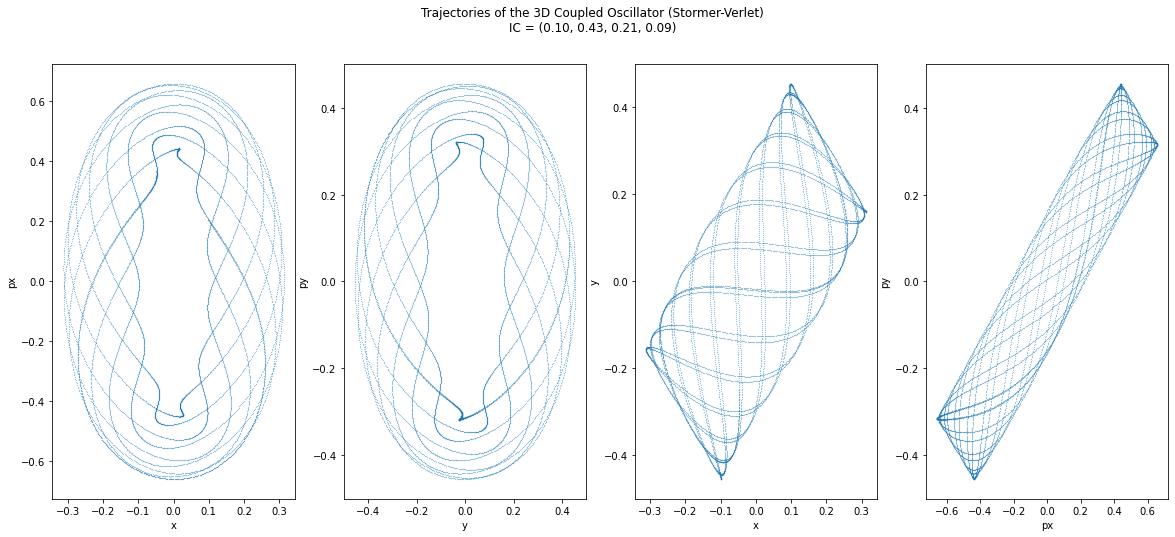

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

l1, l2, m1, m2, g = 1., 1., 1., 1., 1
# x = [theta1, theta2, p1, p2]
f1 = lambda x: np.asarray([(l2*x[2] - l1*x[3]*np.cos(x[0]-x[1]))/((l1**2)*l2*(m1+m2*np.sin(x[0]-x[1])**2)), 
                           (l1*(m1+m2)*x[3]-l2*m2*x[2]*np.cos(x[0]-x[1]))/(l1*(l2**2)*m2*(m1+m2*np.sin(x[0]-x[1])**2))])
C1 = lambda x: x[2]*x[3]*np.sin(x[0]-x[1])/(l1*l2*(m1+m2*np.sin(x[0]-x[1])**2))
C2 = lambda x: ((l2**2)*m2*x[2]**2+(l1**2)*(m1+m2)*x[3]**2-l1*l2*m2*x[2]*x[3]*np.cos(x[0]-x[1]))*(np.sin(2*(x[0]-x[1])))/(2*(l1**2)*(l2**2)*(m1+m2*np.sin(x[0]-x[1])**2)**2)
f2 = lambda x: np.asarray([-(m1+m2)*g*l1*np.sin(x[0])-C1(x)+C2(x),
                           -m2*g*l2*np.sin(x[1])+C1(x)-C2(x)])

np.random.seed(0)
inp = np.random.rand(4)*2-1.


fig, ax = plt.subplots(1,4,figsize = (20,8))
soln = StormerTrajectory(inp,f1,f2,0.01,N=8000,n_h=1)
ax[0].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
ax[1].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
ax[3].scatter(np.asarray(soln)[0][2,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the 3D Coupled Oscillator (Stormer-Verlet)\nIC = (%.2f, %.2f, %.2f, %.2f)" %(inp[0], inp[1], inp[2], inp[3]))
ax[0].set_xlabel("x")
ax[0].set_ylabel("px")
ax[1].set_xlabel("y")
ax[1].set_ylabel("py")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[3].set_xlabel("px")
ax[3].set_ylabel("py")
plt.show()



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm

l1, l2, m1, m2, g = 1., 1., 1., 1., 1
# x = [theta1, theta2, p1, p2]
f1 = lambda x: np.asarray([(l2*x[2] - l1*x[3]*np.cos(x[0]-x[1]))/((l1**2)*l2*(m1+m2*np.sin(x[0]-x[1])**2)), 
                           (l1*(m1+m2)*x[3]-l2*m2*x[2]*np.cos(x[0]-x[1]))/(l1*(l2**2)*m2*(m1+m2*np.sin(x[0]-x[1])**2))])
C1 = lambda x: x[2]*x[3]*np.sin(x[0]-x[1])/(l1*l2*(m1+m2*np.sin(x[0]-x[1])**2))
C2 = lambda x: ((l2**2)*m2*x[2]**2+(l1**2)*(m1+m2)*x[3]**2-l1*l2*m2*x[2]*x[3]*np.cos(x[0]-x[1]))*(np.sin(2*(x[0]-x[1])))/(2*(l1**2)*(l2**2)*(m1+m2*np.sin(x[0]-x[1])**2)**2)
f2 = lambda x: np.asarray([-(m1+m2)*g*l1*np.sin(x[0])-C1(x)+C2(x),
                           -m2*g*l2*np.sin(x[1])+C1(x)-C2(x)])


for i in tqdm(range(10)):
  inp = np.random.rand(4)*2.-1.
  
  fig, ax = plt.subplots(1,4,figsize = (20,8))
  soln = StormerTrajectory(inp,f1,f2,0.01,N=8000,n_h=1)
  ax[0].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
  ax[1].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
  ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
  ax[3].scatter(np.asarray(soln)[0][2,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
  fig.suptitle("Trajectories of the 3D Coupled Oscillator (Stormer-Verlet)\nIC = (%.2f, %.2f, %.2f, %.2f)" %(inp[0], inp[1], inp[2], inp[3]))
  ax[0].set_xlabel("x")
  ax[0].set_ylabel("px")
  ax[1].set_xlabel("y")
  ax[1].set_ylabel("py")
  ax[2].set_xlabel("x")
  ax[2].set_ylabel("y")
  ax[3].set_xlabel("px")
  ax[3].set_ylabel("py")

  plt.show()

Output hidden; open in https://colab.research.google.com to view.